In [153]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [172]:
data = pd.read_csv("Insurance_Marketing-Customer-Value-Analysis (1).csv")

In [173]:
data['to_date'] = pd.to_datetime(data['Effective To Date'],format='%m/%d/%Y')

In [174]:
# data['to_date_year'] = pd.DatetimeIndex(data['to_date']).year
# data['to_date_month'] = pd.DatetimeIndex(data['to_date']).month
# data['to_date_day'] = pd.DatetimeIndex(data['to_date']).day
ref_date = pd.to_datetime('1/1/2011', format='%m/%d/%Y')      # Jan 1, 2011 set as reference date
data['num_days'] = data['to_date'].sub(ref_date)              # Calculating no of days remaining
data['num_months'] = data['num_days']/np.timedelta64(1, 'M')
data['num_days'] = data['num_days']/np.timedelta64(1, 'D')    # Converting num_days to float type
data.head()

Customer       State  Customer Lifetime Value Response  Coverage Education  \
0  BU79786  Washington              2763.519279       No     Basic  Bachelor   
1  QZ44356     Arizona              6979.535903       No  Extended  Bachelor   
2  AI49188      Nevada             12887.431650       No   Premium  Bachelor   
3  WW63253  California              7645.861827       No     Basic  Bachelor   
4  HB64268  Washington              2813.692575       No     Basic  Bachelor   

  Effective To Date EmploymentStatus Gender  Income Location Code  \
0         2/24/2011         Employed      F   56274      Suburban   
1         1/31/2011       Unemployed      F       0      Suburban   
2         2/19/2011         Employed      F   48767      Suburban   
3         1/20/2011       Unemployed      M       0      Suburban   
4          2/3/2011         Employed      M   43836         Rural   

  Marital Status  Monthly Premium Auto  Months Since Last Claim  \
0        Married                    69                       32   
1         Single                    94                       13   
2        Married                   108                       18   
3        Married                   106                       18   
4         Single                    73                       12   

   Months Since Policy Inception  Number of Open Complaints  \
0                              5                          0   
1                             42                          0   
2                             38                          0   
3                             65                          0   
4                             44                          0   

   Number of Policies     Policy Type        Policy Renew Offer Type  \
0                   1  Corporate Auto  Corporate L3           Offer1   
1                   8   Personal Auto   Personal L3           Offer3   
2                   2   Personal Auto   Personal L3           Offer1   
3                   7  Corporate Auto  Corporate L2           Offer1   
4                   1   Personal Auto   Personal L1           Offer1   

  Sales Channel  Total Claim Amount  Vehicle Class Vehicle Size    to_date  \
0         Agent          384.811147   Two-Door Car      Medsize 2011-02-24   
1         Agent         1131.464935  Four-Door Car      Medsize 2011-01-31   
2         Agent          566.472247   Two-Door Car      Medsize 2011-02-19   
3   Call Center          529.881344            SUV      Medsize 2011-01-20   
4         Agent          138.130879  Four-Door Car      Medsize 2011-02-03   

   num_days  num_months  
0      54.0    1.774164  
1      30.0    0.985647  
2      49.0    1.609889  
3      19.0    0.624243  
4      33.0    1.084211

In [175]:
data['present_value'] = (data['Monthly Premium Auto'] * data['Months Since Policy Inception']) - data['Total Claim Amount']
data['customer_left'] = (data['Income'] - data['Monthly Premium Auto'])*(data['num_months'])

In [176]:
# year is always 2011 and we don't need effective and date time
# data.drop(['to_date_year', 'to_date', 'Effective To Date'], axis=1, inplace=True)
data.drop(['to_date', 'Effective To Date'], axis=1, inplace=True)

In [159]:
cols_to_norm = ['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception','Number of Open Complaints','Number of Policies', 'Total Claim Amount', 'num_days', 'num_months', 'present_value', 'customer_left']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

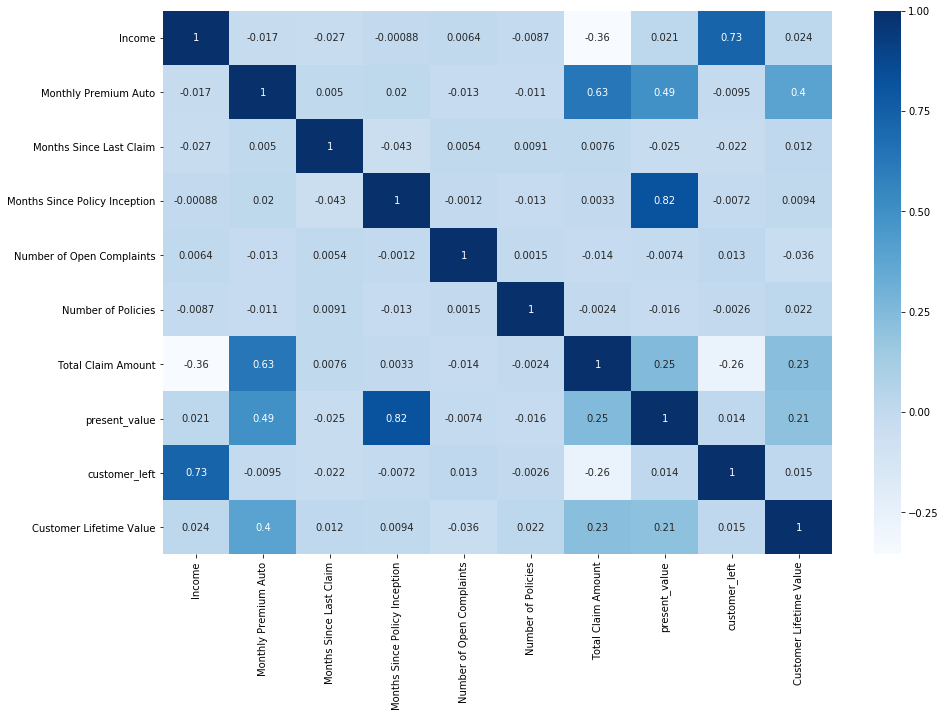

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

cols_to_norm = ['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception','Number of Open Complaints','Number of Policies', 'Total Claim Amount', 'present_value', 'customer_left', 'Customer Lifetime Value']

plt.figure(figsize=(15,10))
cor = data[cols_to_norm].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [160]:
data.drop(['Customer'], axis=1,inplace=True)
data = data = pd.get_dummies(data, drop_first=True)

In [161]:
X = data.drop(['Customer Lifetime Value'], axis=1)
Y = data['Customer Lifetime Value']

# X = np.array(data[['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception'
#                   ,'Total Claim Amount', 'num_days']])
# Y = np.array(data['Customer Lifetime Value'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [162]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
print(type(X_train))

(7307, 54) (1827, 54)
(7307,) (1827,)
<class 'pandas.core.frame.DataFrame'>


### Random Forest Regressor

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [164]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [170]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 76,
 'bootstrap': True}

In [24]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

NameError: name 'rf_random' is not defined

In [25]:
def model_test(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    mae_error_test = mean_absolute_error(Y_test, test_pred)
    mae_error_train = mean_absolute_error(Y_train, train_pred)
    r2_test = r2_score(Y_test, test_pred)
    r2_train = r2_score(Y_train, train_pred)
    return (mae_error_test, mae_error_train, r2_test, r2_train)

In [30]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

model_list = ['Lasso', 'Ridge', 'LinearRegression', 'BayesianRidge', 'SVM', 'Decision Tree', 'AdaBoost', 'RandomForest', 'XGboost']
models = [Lasso(), Ridge(), LinearRegression(), BayesianRidge(), SVR(), DecisionTreeRegressor(), AdaBoostRegressor(), RandomForestRegressor(), XGBRegressor()]

accuracy_dict = {}

for mod, mod_name in zip(models, model_list):
    accuracy_dict[mod_name] = model_test(mod, X_train, Y_train, X_test, Y_test)

/home/shivansh/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/shivansh/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/shivansh/anaconda3/envs/dl/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:39:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Lasso

In [47]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score
model = Lasso()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 4194.352265415865
R2 on test: 0.1585819299439013
R2 on train: 0.17076407141272787


### Ridge Regression

In [53]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 4198.822892503993
R2 on test: 0.1584228024682114
R2 on train: 0.17074566666172963


### Linear Regression

In [344]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 3988.861356650142
R2 on test: 0.1516024624605552
R2 on train: 0.1602431897727481


### BayesianRidge

In [345]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 4567.871917907643
R2 on test: -0.00015471201346550778
R2 on train: 1.9308166310239017e-07


### SVM

In [346]:
from sklearn import svm
model = svm.SVR()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 4129.527246793341
R2 on test: -0.08635952386462886
R2 on train: -0.1049051450180778


### Decision Tree

In [347]:
from sklearn import tree
model = tree.DecisionTreeRegressor()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 5088.249683023536
R2 on test: -0.5439262953679109
R2 on train: 1.0


### AdaBoost

In [348]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(n_estimators = 15)  # Near optimal value: 15 ; falls sharply after 20
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 7122.41095687919
R2 on test: -0.3685215447973176
R2 on train: -0.484212793697433


### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50)
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 1558.2118052198878
R2 on test: 0.6564046671230891
R2 on train: 0.9574373497815171


### Clustering

In [139]:
data_c = data.copy()
data_c = data_c.sort_values('Customer Lifetime Value')
data_c['labels'] = -1
for idx, i in enumerate(data_c.index.tolist()):
    if( int(idx/(int(data_c.shape[0]/3))) < 2):
        data_c.loc[i,'labels'] = 0
    else:
        data_c.loc[i,'labels'] = 1
data_c.drop(['Customer Lifetime Value'], axis=1, inplace=True)
X_clas = data_c.drop(['labels'], axis=1)
Y_clas = data_c.labels
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_clas, Y_clas, test_size=test_size, random_state=seed)
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from xgboost import plot_importance
plot_importance(model, max_num_features=20)

In [191]:
( (data_c.groupby('labels')['Months Since Last Claim'].mean()[1])*(data['Months Since Last Claim'].max() - data['Months Since Last Claim'].min())) + (data['Months Since Last Claim'].min()) 

14.94386080105055